# Environment
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

In [1]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner
import glob
import h5py
import pandas as pd
import seaborn as sns

### Functions

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=2.0)

# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    return Mf,jf

# 2D histogram
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    return P_xy, P_x, P_y, x_intp, y_intp, s1, s2

# Priors

/home/abhirup.ghosh/envs/pSEOBNRv4HM_tgr_injections/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


(0, 40)

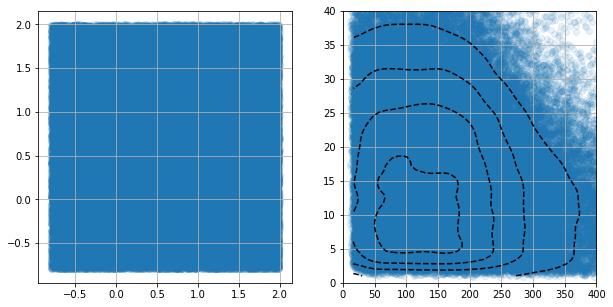

In [4]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

N_samples = 100000

domega_prior, dtau_prior = np.random.uniform(-0.8,2,N_samples), np.random.uniform(-0.8,2,N_samples)

P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega_prior, dtau_prior, N_bins=100)
ax1.scatter(domega_prior, dtau_prior, alpha=0.1)
ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='k', linestyles='dashed')
ax1.grid(True)

m1_prior, m2_prior = np.random.uniform(30,150,N_samples), np.random.uniform(30,150,N_samples)

a1z_prior, a2z_prior = np.random.uniform(-1,1,N_samples), np.random.uniform(-1,1,N_samples) 

freq_GR_prior, tau_GR_prior, freq_modGR_prior, tau_modGR_prior = eff_quant(m1_prior, m2_prior, \
                                                                           a1z_prior, a2z_prior, \
                                                                           domega_prior, dtau_prior, [2,2])
#mf_modGR_prior, af_modGR_prior = Mjfinal220(freq_modGR_prior*2*np.pi,tau_modGR_prior)

P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR_prior, tau_modGR_prior*1000, N_bins=100)

ax2.scatter(freq_modGR_prior, tau_modGR_prior*1000, alpha=0.1)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=4, colors='k', linestyles='dashed')
ax2.grid(True)
ax2.set_xlim([0,400])
ax2.set_ylim([0,40])

# Software Injections: GR/nonGR

## GW150914-GW190521 domega-dtau plots

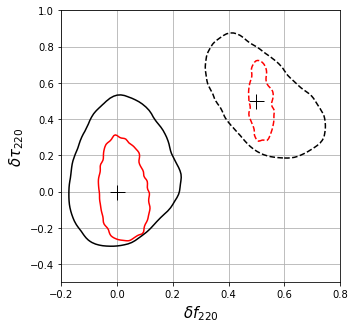

In [5]:
event_list = ['GW150914', 'GW190521']
color_list = ['r','k']

run_list_modGR = ['domega220_dtau220_0p0', 'domega220_dtau220_0p5']
ls_list = ['solid','dashed']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for (color,event) in zip(color_list,event_list):
    for (ls, run) in zip(ls_list,run_list_modGR):
        
        if event == 'GW190521':
            data_loc = glob.glob('../runs/nonGR/%s-like/%s/cbcBayes/posterior_samples.dat'%(event, run))[0]
        else:
            data_loc = glob.glob('../runs/nonGR/%s-like/%s/*/*/posterior_samples.dat'%(event, run))[0]


        data = np.genfromtxt(data_loc, dtype=None, names=True)

        m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
        freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
        mf_modGR, af_modGR = Mjfinal220(freq_modGR*2*np.pi,tau_modGR)

        P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)

        ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color, linestyles=ls)
        ax1.grid(True)
        
ax1.plot(0,0,'k+',ms=15)
ax1.plot(0.5,0.5,'k+',ms=15)
ax1.set_xlabel("$\delta f_{220}$", size=15)
ax1.set_ylabel(r"$\delta\tau_{220}$", size=15) 
ax1.set_xlim([-0.2,0.8])
ax1.set_ylim([-0.5,1.0])
plt.savefig('../papers/intro_paper/figures/GW150914_GW190521_simulated_frac.png', dpi=300)


## GW150914-GW190521: omega-tau plot

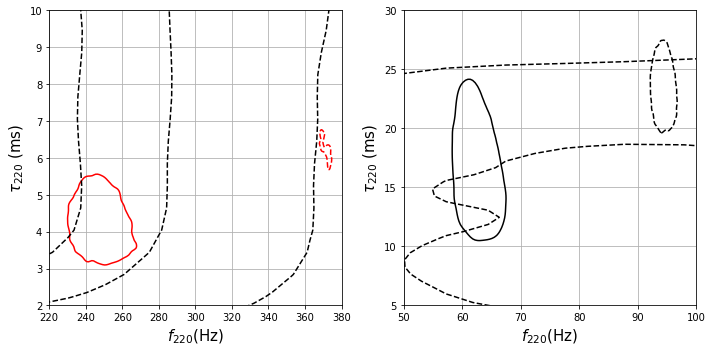

In [7]:
event_list = ['GW150914', 'GW190521']
color_list = ['r','k']

run_list_GR = ['domega220_dtau220_0p0_GR','domega220_dtau220_0p5_GR']
run_list_modGR = ['domega220_dtau220_0p0', 'domega220_dtau220_0p5']
ls_list = ['solid','dashed']

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for (color,event) in zip(color_list,event_list):
    for (ls, run) in zip(ls_list,run_list_modGR):

        if event == 'GW150914':
            data_loc = glob.glob('../runs/nonGR/%s-like/%s/*/*/posterior_samples.dat'%(event, run))[0]
            
            data = np.genfromtxt(data_loc, dtype=None, names=True)
            
            m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
            freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
        
            mf_modGR, af_modGR = Mjfinal220(freq_modGR*2*np.pi,tau_modGR)

            P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR*1000, N_bins=100)

            ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color, linestyles=ls)
            ax1.grid(True)
        
        
        elif event == 'GW190521':
            data_loc = glob.glob('../runs/nonGR/%s-like/%s/cbcBayes/posterior_samples.dat'%(event, run))[0]
        
            data = np.genfromtxt(data_loc, dtype=None, names=True)
            
            m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
            freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
        
            mf_modGR, af_modGR = Mjfinal220(freq_modGR*2*np.pi,tau_modGR)

            P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR*1000, N_bins=100)

            ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color, linestyles=ls)
            ax2.grid(True)


ax1.set_xlabel("$f_{220}$(Hz)", size=15)
ax1.set_ylabel(r"$\tau_{220}$ (ms)", size=15)
ax2.set_xlabel("$f_{220}$(Hz)", size=15)
ax2.set_ylabel(r"$\tau_{220}$ (ms)", size=15) 

ax1.set_xlim([220, 380])
ax1.set_ylim([2,10])

ax2.set_xlim([50, 100])
ax2.set_ylim([5,30])

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW150914_GW190521_simulated_abs.png', dpi=300)

P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR_prior, tau_modGR_prior*1000., N_bins=100)            
            
ax1.contour(x_intp, y_intp, gf(P_xy), levels=4, colors='k', linestyles='dashed')
ax2.contour(x_intp, y_intp, gf(P_xy), levels=4, colors='k', linestyles='dashed')

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW150914_GW190521_simulated_abs_w_prior.png', dpi=300)

## No-hair test with SXS:BBH:0166

In [ ]:
data_220 = '../runs/parallel_bilby/GW150914_SXS_BBH_0166/outdir/'

## O1-O2 events

GW150914
GW170104
GW170729


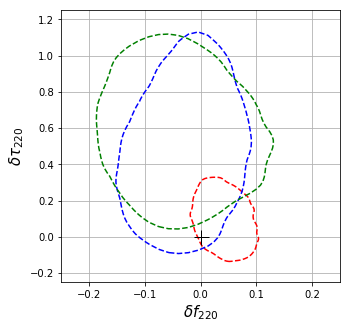

In [105]:
import json

event_list = ["GW150914", "GW170104", "GW170729"]#, "GW170814", "GW170823"]
color_list = ["r", "b", "g"]

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for (color,event) in zip(color_list,event_list):
    
    print(event)

    postloc_nongr = "../runs/parallel_bilby/%s_pSEOBNRv4HM/outdir/%s_result.json"%(event, event)
    
    with open(postloc_nongr, "r") as f:
        data = json.load(f)
   

    m1, m2, domega, dtau = data['posterior']['content']["mass_1"], \
    data['posterior']['content']["mass_2"], \
    data['posterior']['content']["domega220"], \
    data['posterior']['content']["dtau220"]
    
    m1, m2, domega, dtau = np.array(m1), np.array(m2), np.array(domega), np.array(dtau)
    a1z, a2z = np.zeros(len(m1)), np.zeros(len(m1))
    
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
    mf_modGR, af_modGR = Mjfinal220(freq_modGR*2*np.pi,tau_modGR)
 
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)

    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color, linestyles=ls)
    ax1.grid(True)
    

ax1.set_xlabel("$\delta f_{220}$", fontsize=15)
ax1.set_ylabel("$\delta \\tau_{220}$", fontsize=15)
ax1.plot(0,0,'k+',ms=15)
ax1.set_xlim([-0.25,0.25])
ax1.set_ylim([-0.25,1.25])
plt.savefig('../papers/intro_paper/figures/O1O2_realevents.png', dpi=300)

# Noise Systematics

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, '$\\tau$ (ms)')

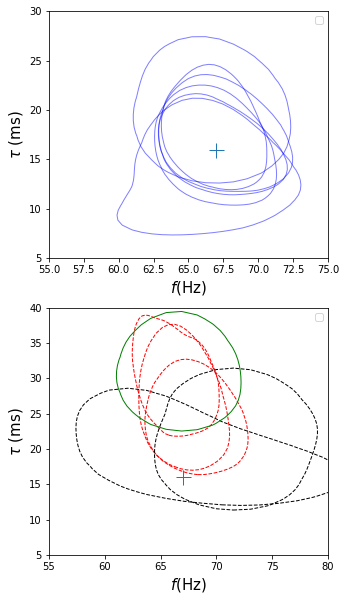

In [109]:
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Gaussian Noise

postloc = '../runs/parallel_bilby'
noise_list = ["noise01", "noise02", "noise03", "noise04", "noise05", "zeronoise"]

for (idx, noise) in enumerate(noise_list):
    f, tau = np.genfromtxt(postloc + '/S190521g_NRSurEXP30inj_pSEOBNRv4HM_%s/pesummary/samples/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%noise, unpack=True)
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
    ax1.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='b', alpha=0.5)

ax1.legend(loc="best")
ax1.plot(67, 16, "+", ms=15)    
ax1.set_xlim([55,75])
ax1.set_ylim([5, 30])
ax1.set_xlabel("$f$(Hz)", size=15)
ax1.set_ylabel(r"$\tau$ (ms)", size=15)    

## Real Noise

postloc = '../runs/review/21g_injections/NRSur7dq4_MaxL_EXP30_realnoise'
gpstime_list = ["1242461657", "1242463457", "1242456257", "1242458057", "1242454457"]

for gpstime in gpstime_list:
    f, tau = np.genfromtxt(postloc + "/%s/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat"%gpstime, unpack=True)
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
    if gpstime == "1242458057" or gpstime == "1242454457":
        ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='k', linestyles=("dashed",))
    else: 
        ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='r', linestyles=("dashed",))

# Actual Event        
  
postloc = '../runs/O3a/GW190521a/220_rererun_newpsd'    
f, tau = np.genfromtxt(postloc + "/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat", unpack=True)
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='g', linestyles=("solid",))
        

ax2.legend(loc="best")
ax2.plot(67, 16, "+", ms=15)    
ax2.set_xlim([55,80])
ax2.set_ylim([5, 40])
ax2.set_xlabel("$f$(Hz)", size=15)
ax2.set_ylabel(r"$\tau$ (ms)", size=15)

### SXS:BBH:0166

#### 220/330

In [ ]:
postloc = '../runs/parallel_bilby/GW150914_SXS_BBH_0166_330/pesummary/samples/1594069675_GW150914_checkpoint_preresult_pesummary.dat'
data = np.genfromtxt(postloc, names=True, dtype=None)

m1, m2, a1z, a2z, domega, dtau = data["mass_1"], data["mass_2"], data["chi_1"], data["chi_2"], data["domega330"], data["dtau330"]

# create (omega, tau)_GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, [3,3])
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR*1000, 50)
ax.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='k', alpha=0.5)


ax.legend(loc="best")
ax.plot(265, 5, "+", ms=20)    
#plt.xlim([55,75])
#plt.ylim([5, 30])
plt.xlabel("$f$(Hz)", size=20)
plt.ylabel(r"$\tau$ (ms)", size=20)